
# Deep Learning Homework 6 (Spring 2023)

This code is provided for Deep Learning class (601.482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu. Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, Keith Harrigian, and Yiqing Shen.


### Imports

In [2]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [ ]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

# Problem 1: Unsupervised Pre-training

### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

Dataset is available at: https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/yshen92_jh_edu/EcTxWAXsAhtDiv3vUxCTF8gBgAARCUvvKthb3s-pEExyMg

In [ ]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 100

### Data Paths

In [ ]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/MLDL_HW6/DeepLearning_Fall2023_HW6_data/HW6_data"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [ ]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):

    """
    ImageDataset
    """

    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset

        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """

        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """

        """
        ## Load Image and Parse Properties
        img_name = str(idx) + '_input.jpg'
        mask_name = str(idx) + '_mask.png'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        if len(mask.shape) == 2:
            h, w  = mask.shape
        elif len(mask.shape) == 3:
            h, w, c = mask.shape
        ## Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        for idx in range(self.mask_num):
            #if the mask has 3 dimension use this code
            new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
            #if the mask has 1 dimension use the code below
            #new_mask[:, :, idx] = mask == self.mask_value[idx]
        ## Transform image and mask
        if self.transform:
            img, mask = self.img_transform(img, new_mask)
        # ## Use dictionary to output
        # sample = {'img': img, 'mask': mask}
        # return sample
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """

        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

## Model Architecture

Finish building the U-net architecture below.

In [ ]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """

    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """

    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):

    """

    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        self.out = nn.Conv2d(32,n_classes, kernel_size = 1, stride = 1, padding = 0, bias = True)
        self.softmax = nn.Softmax()

    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        out = self.softmax(self.out(conv1m_out))

        return out

### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [ ]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes

      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    assert prediction.shape[0] == 1 #This line can not be deleted
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    dice_classes = np.zeros(n_classes)
    for cl in range(n_classes):
        pred = (prediction[0] == cl).float()
        label = target[0, cl, :, :]

        TP = (pred * label).sum()
        FP = (pred * (1 - label)).sum()
        FN = ((1 - pred) * label).sum()
        #When there is no ground truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0,
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
        if TP == 0 and FN == 0:
            if FP == 0:
              dice_classes[cl] = 1
            elif FP > 0:
              dice_classes[cl] = 0
        else:
          dice_classes[cl] = (2 * TP) / (2*TP + FP + FN)
    return dice_classes.mean()



def dice_score_dataset(model, dataloader, num_classes, use_gpu=False):
    """
    Compute the mean dice score on a set of data.

    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.

    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does

    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes

    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


## TODO: Implement DICE loss,
#  It should conform to to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self, num_classes):
      super(DICELoss, self).__init__()
      self.num_classes = num_classes
    def forward(self, input, target):
      intersection = 0
      pred_sum = 0
      label_sum = 0
      for i in range(input.shape[0]):
        for cl in range(self.num_classes):
          pred = input[i, cl, :, :]
          label = target[i, cl, :, :]
          intersection += (pred * label).sum()
          pred_sum += (pred * pred).sum()
          label_sum += (label * label).sum()
      total_loss = 1 - (2 * intersection)/(pred_sum + label_sum)
      return total_loss

## Training Procedure (Segmentation)

In [ ]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = DICELoss(n_classes)
model = model.cuda()

# Define lists to store training and validation losses
train_losses = []
val_losses = []
test_score = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    # Iterate through the training data
    for inputs, labels in train_dataloader:
      inputs = inputs.cuda()
      labels = labels.cuda()
      output = model.forward(inputs)
      loss = criterion.forward(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for inputs, labels in validation_dataloader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        output = model(inputs)
        loss = criterion.forward(output, labels)
        val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    test_score_i = dice_score_dataset(model, test_dataloader, n_classes, use_gpu=gpu_bool)
    test_score.append(test_score_i)
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    print(f'Test Score: {test_score_i:.4f}')

Start Training...

EPOCH 1 of 100



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/100], Train Loss: 0.3988, Val Loss: 0.2168
Test Score: 0.5909

EPOCH 2 of 100

Epoch [2/100], Train Loss: 0.2262, Val Loss: 0.1446
Test Score: 0.6099

EPOCH 3 of 100

Epoch [3/100], Train Loss: 0.1499, Val Loss: 0.1124
Test Score: 0.5028

EPOCH 4 of 100

Epoch [4/100], Train Loss: 0.1098, Val Loss: 0.1014
Test Score: 0.5022

EPOCH 5 of 100

Epoch [5/100], Train Loss: 0.0947, Val Loss: 0.1183
Test Score: 0.5234

EPOCH 6 of 100

Epoch [6/100], Train Loss: 0.0824, Val Loss: 0.0766
Test Score: 0.4657

EPOCH 7 of 100

Epoch [7/100], Train Loss: 0.0756, Val Loss: 0.1432
Test Score: 0.3881

EPOCH 8 of 100

Epoch [8/100], Train Loss: 0.0725, Val Loss: 0.0766
Test Score: 0.5347

EPOCH 9 of 100

Epoch [9/100], Train Loss: 0.0698, Val Loss: 0.0696
Test Score: 0.5196

EPOCH 10 of 100

Epoch [10/100], Train Loss: 0.0650, Val Loss: 0.0701
Test Score: 0.5394

EPOCH 11 of 100

Epoch [11/100], Train Loss: 0.0599, Val Loss: 0.0613
Test Score: 0.5804

EPOCH 12 of 100

Epoch [12/100], Train Loss:

In [ ]:
max_score = max(test_score)
max_score_idx = test_score.index(max_score)
print(f'At Epoch {max_score_idx}, Test DICE score reaches its max as: {max_score:.4f}')

At Epoch 19, Test DICE score reaches its max as: 0.6440


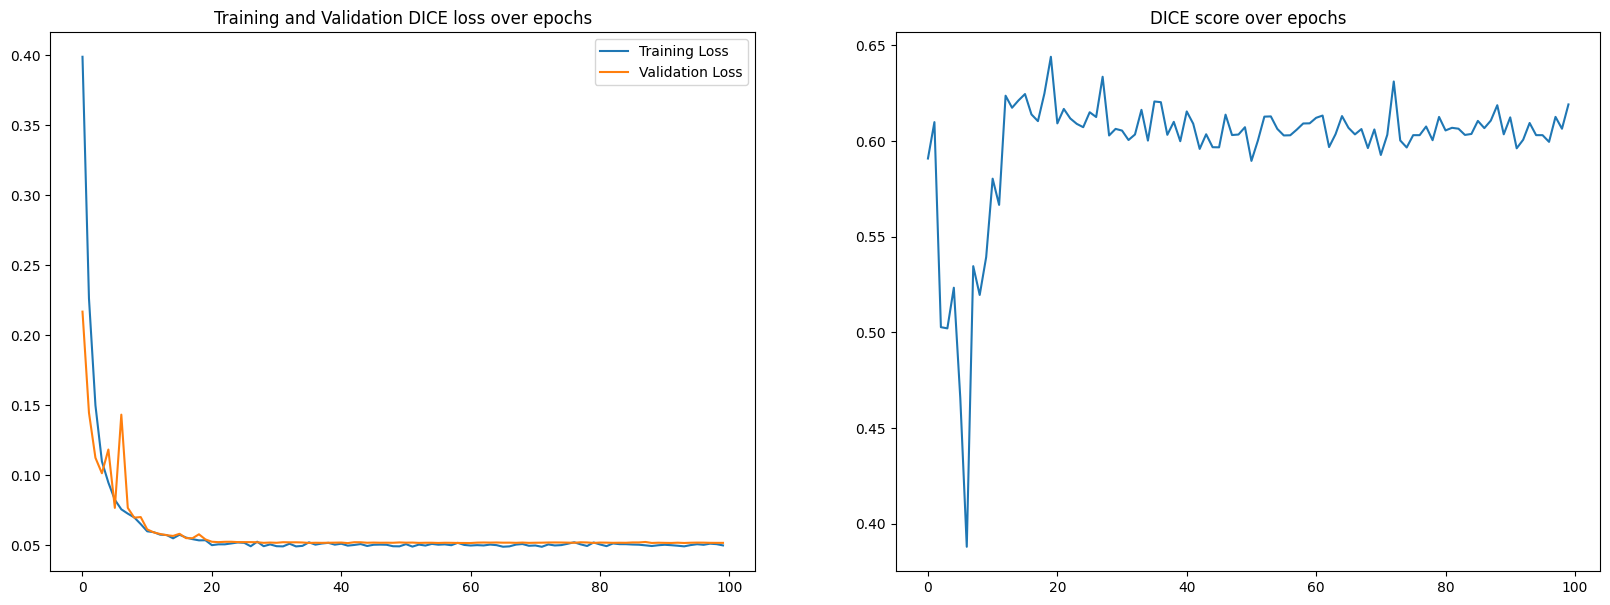

In [ ]:
# Graph
fig, axs = plt.subplots(1, 2,figsize=(20, 7))

axs[0].plot(range(num_epochs), train_losses)
axs[0].plot(range(num_epochs), val_losses)
axs[0].legend(['Training Loss', 'Validation Loss'])
axs[0].set_title('Training and Validation DICE loss over epochs')

axs[1].plot(range(num_epochs), test_score)
axs[1].set_title('DICE score over epochs')

plt.show()

## Data Augmentation

In [ ]:
## Augmented Image Transforms
augmented_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
])

In [ ]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=augmented_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = DICELoss(n_classes)
model = model.cuda()

# Define lists to store training and validation losses
train_losses = []
val_losses = []
test_score = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    # Iterate through the training data
    for inputs, labels in train_dataloader:
      # Forward pass
      inputs = inputs.cuda()
      labels = labels.cuda()
      output = model.forward(inputs)

      # Compute loss
      loss = criterion.forward(output, labels)

      # Backpropagation
      optimizer.zero_grad()  # Zero the gradients
      loss.backward()
      optimizer.step()

    # Update running training loss
      train_loss += loss.item()

    # Compute average training loss for the epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for inputs, labels in validation_dataloader:
        if gpu_bool:
          inputs = inputs.cuda()
          labels = labels.cuda()
        output = model(inputs)
        loss = criterion.forward(output, labels)
        val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)

    ########################### Test #####################################
    test_score_i = dice_score_dataset(model, test_dataloader, n_classes, use_gpu=gpu_bool)
    test_score.append(test_score_i)
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    print(f'Test Score: {test_score_i:.4f}')

Start Training...

EPOCH 1 of 100

Epoch [1/100], Train Loss: 0.5144, Val Loss: 0.3952
Test Score: 0.3992

EPOCH 2 of 100

Epoch [2/100], Train Loss: 0.3254, Val Loss: 0.3205
Test Score: 0.2604

EPOCH 3 of 100

Epoch [3/100], Train Loss: 0.2249, Val Loss: 0.2182
Test Score: 0.5009

EPOCH 4 of 100

Epoch [4/100], Train Loss: 0.1820, Val Loss: 0.1834
Test Score: 0.5757

EPOCH 5 of 100

Epoch [5/100], Train Loss: 0.1600, Val Loss: 0.1823
Test Score: 0.3985

EPOCH 6 of 100

Epoch [6/100], Train Loss: 0.1547, Val Loss: 0.1637
Test Score: 0.6829

EPOCH 7 of 100

Epoch [7/100], Train Loss: 0.1480, Val Loss: 0.1847
Test Score: 0.5854

EPOCH 8 of 100

Epoch [8/100], Train Loss: 0.1455, Val Loss: 0.1583
Test Score: 0.6540

EPOCH 9 of 100

Epoch [9/100], Train Loss: 0.1440, Val Loss: 0.1566
Test Score: 0.6669

EPOCH 10 of 100

Epoch [10/100], Train Loss: 0.1421, Val Loss: 0.1551
Test Score: 0.6559

EPOCH 11 of 100

Epoch [11/100], Train Loss: 0.1406, Val Loss: 0.1518
Test Score: 0.6799

EPOCH 12 

In [ ]:
max_score = max(test_score)
max_score_idx = test_score.index(max_score)
print(f'At Epoch {max_score_idx}, Test DICE score reaches its max as: {max_score:.4f}')

At Epoch 75, Test DICE score reaches its max as: 0.6831


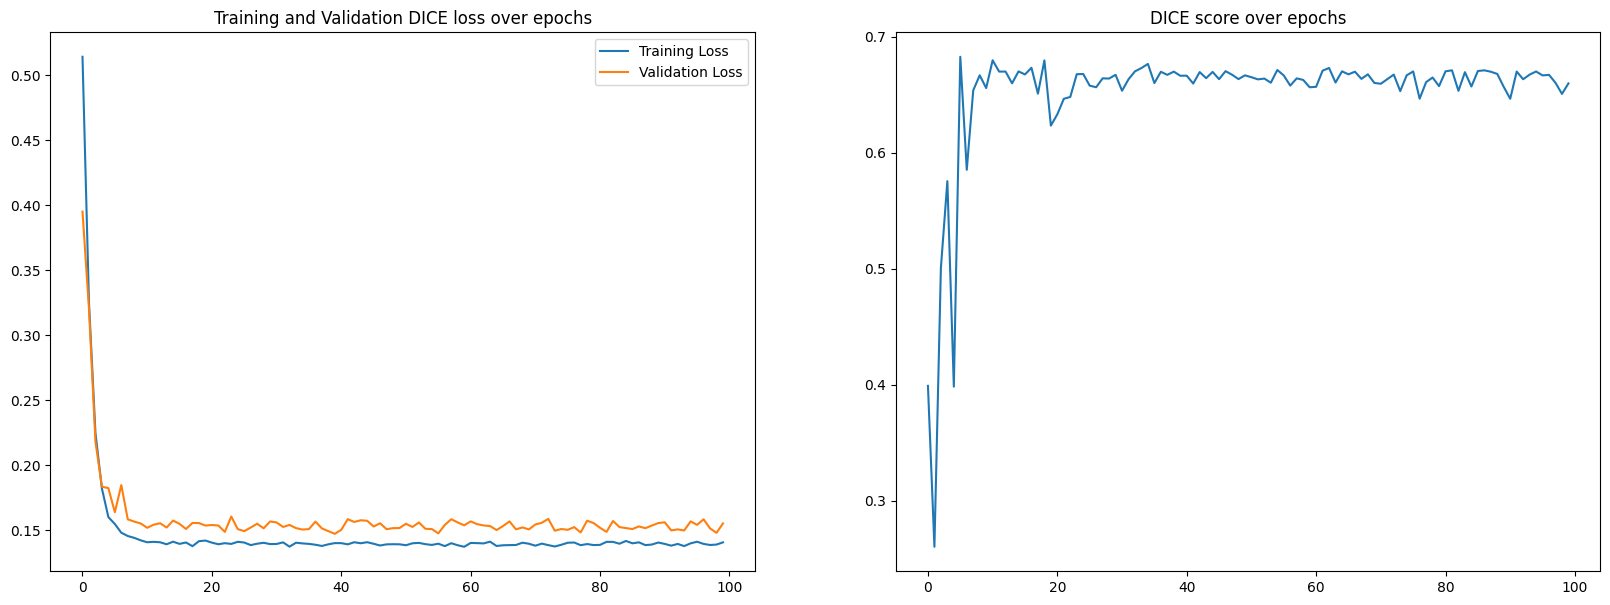

In [ ]:
# Graph
fig, axs = plt.subplots(1, 2,figsize=(20, 7))

axs[0].plot(range(num_epochs), train_losses)
axs[0].plot(range(num_epochs), val_losses)
axs[0].legend(['Training Loss', 'Validation Loss'])
axs[0].set_title('Training and Validation DICE loss over epochs')

axs[1].plot(range(num_epochs), test_score)
axs[1].set_title('DICE score over epochs')

plt.show()

## Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

In [ ]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate|
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

In [ ]:
## Augmented Image Transforms
augmented_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
])
## Image Dataloader
class ColorDataset(Dataset):

    """
    ImageDataset
    """

    def __init__(self,
                 input_dir,
                 op,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset

        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        # Get directories
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
        except ValueError:
            print('op should be either train or val!')

    def __len__(self):
        """

        """
        return len(next(os.walk(self.data_dir))[1])-1

    def __getitem__(self,
                    idx):
        """

        """
        ## Load Image and Parse Properties
        idx = idx + 1
        img_name = str(idx) + '_gray.jpg'
        mask_name = str(idx) + '_input.jpg'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        if self.transform:
            img, mask = self.img_transform(img, mask)
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """

        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)
        img = img.repeat(3,1,1)
        return img, mask

In [ ]:
## Initialize your unet
n_classes = 3
model = UNET(n_classes)

## Initialize Dataloaders
train_dataset=ColorDataset(input_dir=colorization_data_dir, op="train", transforms=augmented_transform)
validation_dataset=ColorDataset(input_dir=colorization_data_dir, op="val", transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()
gpu_bool = torch.cuda.is_available()
if gpu_bool:
  model = model.cuda()

# Define lists to store training and validation losses
train_losses = []
val_losses = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    # Iterate through the training data
    for inputs, labels in train_dataloader:

      # Forward pass
      if gpu_bool:
        inputs = inputs.cuda()
        labels = labels.cuda()
      output = model.forward(inputs)

      # Compute loss
      loss = criterion.forward(output, labels)

      # Backpropagation
      optimizer.zero_grad()  # Zero the gradients
      loss.backward()
      optimizer.step()

      # Update running training loss
      train_loss += loss.item()

    # Compute average training loss for the epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for inputs, labels in validation_dataloader:
        if gpu_bool:
          inputs = inputs.cuda()
          labels = labels.cuda()
        output = model(inputs)
        loss = criterion.forward(output, labels)
        val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Start Training...

EPOCH 1 of 50

Epoch [1/50], Train Loss: 0.0356, Val Loss: 0.0290

EPOCH 2 of 50

Epoch [2/50], Train Loss: 0.0353, Val Loss: 0.0286

EPOCH 3 of 50

Epoch [3/50], Train Loss: 0.0353, Val Loss: 0.0287

EPOCH 4 of 50

Epoch [4/50], Train Loss: 0.0353, Val Loss: 0.0290

EPOCH 5 of 50

Epoch [5/50], Train Loss: 0.0352, Val Loss: 0.0294

EPOCH 6 of 50

Epoch [6/50], Train Loss: 0.0352, Val Loss: 0.0288

EPOCH 7 of 50

Epoch [7/50], Train Loss: 0.0352, Val Loss: 0.0288

EPOCH 8 of 50

Epoch [8/50], Train Loss: 0.0352, Val Loss: 0.0288

EPOCH 9 of 50

Epoch [9/50], Train Loss: 0.0352, Val Loss: 0.0287

EPOCH 10 of 50

Epoch [10/50], Train Loss: 0.0352, Val Loss: 0.0288

EPOCH 11 of 50

Epoch [11/50], Train Loss: 0.0352, Val Loss: 0.0285

EPOCH 12 of 50

Epoch [12/50], Train Loss: 0.0352, Val Loss: 0.0286

EPOCH 13 of 50

Epoch [13/50], Train Loss: 0.0351, Val Loss: 0.0286

EPOCH 14 of 50

Epoch [14/50], Train Loss: 0.0351, Val Loss: 0.0286

EPOCH 15 of 50

Epoch [15/50], Tr

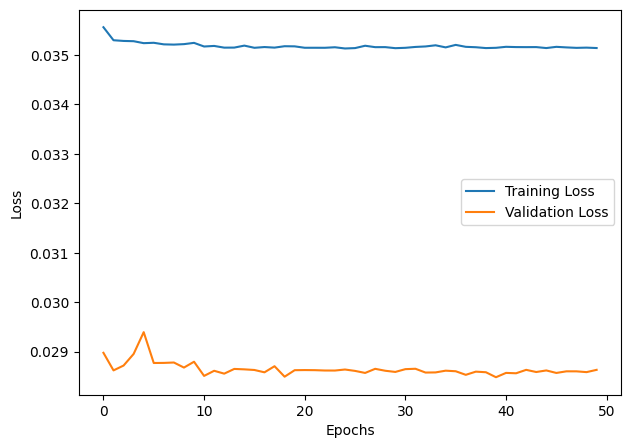

In [ ]:
fig = plt.figure(figsize=(7, 5)) # create the canvas for plotting
ax = plt.subplot()
ax.plot(train_losses, label = "Training Loss")
ax.plot(val_losses, label = "Validation Loss")
handles, labels = ax.get_legend_handles_labels()

ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.legend(handles, labels)

plt.show()


In [ ]:
torch.save(model.state_dict(), f'{data_dir}/color_pretrained.dict')
model = UNET(3)
model.load_state_dict(torch.load(f'{data_dir}/color_pretrained.dict', map_location=torch.device('cpu')))
train_dataset=ColorDataset(input_dir=colorization_data_dir, op="train", transforms=img_transform)

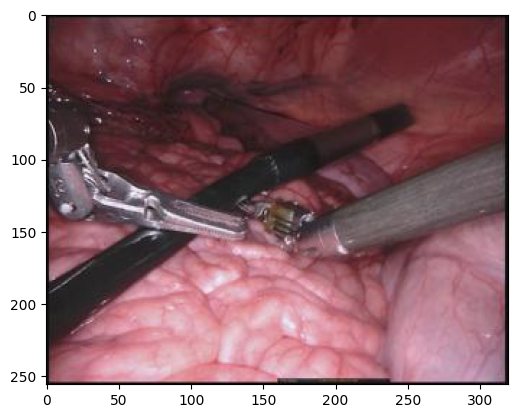

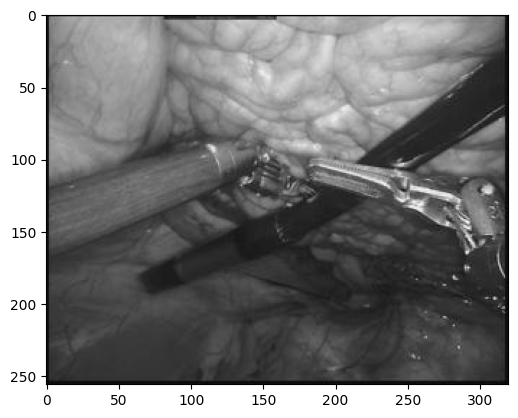

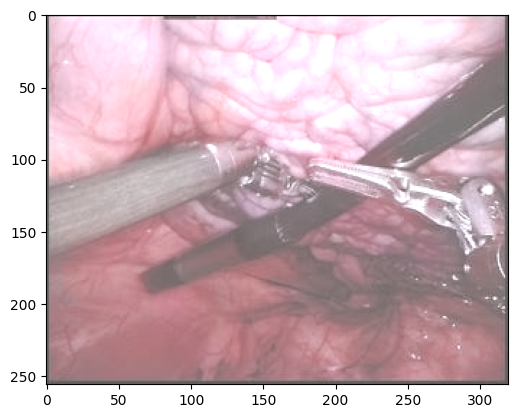

In [ ]:
model.eval()
plt.figure()
img, label = train_dataset[2]
plt.imshow(label.cpu().permute(1,2,0).numpy())
plt.figure()
img, label = train_dataset[2]
plt.imshow(img.cpu().permute(1,2,0).numpy())
with torch.no_grad():
  plt.figure()

  plt.imshow(img.cpu().permute(1,2,0).numpy()+model(torch.unsqueeze(img,0)).squeeze().permute(1, 2, 0).cpu().numpy())

## Use Color Pretrained Model on Segmentation dataset

In [ ]:
n_classes = 6
model.out_layer = nn.Conv2d(32, n_classes, kernel_size = 1, stride = 1, padding = 0, bias = True)
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate|
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 100

In [ ]:
## Initialize your unet
n_classes = 6
model = UNET(n_classes)

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=augmented_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_func = DICELoss(n_classes)
model = model.cuda()

# Define lists to store training and validation losses
train_losses = []
val_losses = []
test_score = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    # Iterate through the training data
    for inputs, labels in train_dataloader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        output = model.forward(inputs)

        loss = loss_func.forward(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # Update running training loss
        train_loss += loss.item()

    # Compute average training loss for the epoch
    train_loss = train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for inputs, labels in validation_dataloader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        output = model(inputs)
        loss = criterion.forward(output, labels)
        val_loss += loss.item()

    val_loss = val_loss / len(validation_dataloader)
    val_losses.append(val_loss)
    test_score_i = dice_score_dataset(model, test_dataloader, n_classes, use_gpu=gpu_bool)
    test_score.append(test_score_i)
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    print(f'Test Score: {test_score_i:.4f}')

Start Training...

EPOCH 1 of 100

Epoch [1/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.3601

EPOCH 2 of 100

Epoch [2/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.3434

EPOCH 3 of 100

Epoch [3/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.3954

EPOCH 4 of 100

Epoch [4/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.5849

EPOCH 5 of 100

Epoch [5/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.6144

EPOCH 6 of 100

Epoch [6/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.5524

EPOCH 7 of 100

Epoch [7/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.3340

EPOCH 8 of 100

Epoch [8/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.5642

EPOCH 9 of 100

Epoch [9/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.5727

EPOCH 10 of 100

Epoch [10/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.6628

EPOCH 11 of 100

Epoch [11/100], Train Loss: 0.0351, Val Loss: 0.0286
Test Score: 0.6200

EPOCH 12 

In [ ]:
max_score = max(test_score)
max_score_idx = test_score.index(max_score)
print(f'At Epoch {max_score_idx}, Test DICE score reaches its max as: {max_score:.4f}')

At Epoch 75, Test DICE score reaches its max as: 0.6831


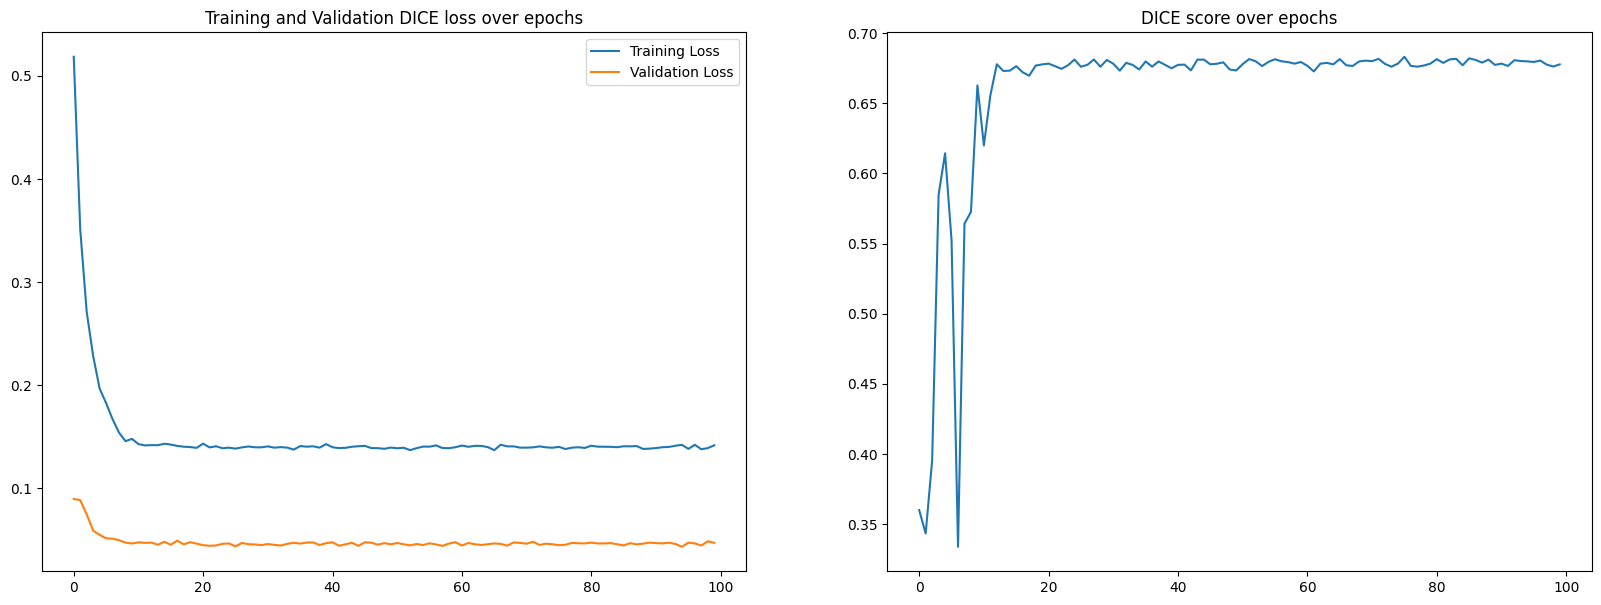

In [ ]:
# Graph
fig, axs = plt.subplots(1, 2,figsize=(20, 7))

axs[0].plot(range(num_epochs), train_losses)
axs[0].plot(range(num_epochs), val_losses)
axs[0].legend(['Training Loss', 'Validation Loss'])
axs[0].set_title('Training and Validation DICE loss over epochs')

axs[1].plot(range(num_epochs), test_score)
axs[1].set_title('DICE score over epochs')

plt.show()

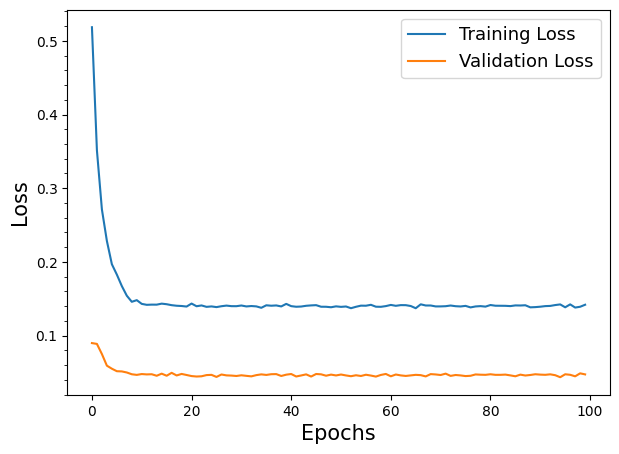

In [ ]:
fig = plt.figure() # create the canvas for plotting
ax = plt.subplot()
ax.plot(train_losses, label = "Training Loss")
ax.plot(val_losses, label = "Validation Loss")
handles, labels = ax.get_legend_handles_labels()

ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.legend(handles, labels)

plt.show()

# Problem 2: Transfer Learning

### Imports

In [47]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

### Data Loading

In [48]:
## Specify Batch Size
train_batch_size = 32
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 18023259.01it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 305220.98it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5588060.85it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20466613.26it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

In [57]:
model = vgg16(pretrained=False)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=10)
model = model.cuda()

def initialize_weights(m):
  """
  Initialize the weights and biases of the model.
  """
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
      torch.nn.init.kaiming_uniform_(m.weight)
      torch.nn.init.uniform_(m.bias)

model.apply(initialize_weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model = model.cuda()

criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
num_epochs = 10

# Define lists to store training and validation losses
train_losses = []
accuracy = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    # Iterate through the training data
    for inputs, labels in training_dataloader:
      inputs = inputs.cuda()
      labels = labels.cuda()
      output = model.forward(inputs)
      loss = criterion(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    # Compute average training loss for the epoch
    avg_train_loss = train_loss / len(training_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')


    ########################### Test #####################################
    # TODO: Design your own Test section
    model.eval()
    test_loss = 0.0
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
          if gpu_bool:
            inputs = inputs.cuda()
            labels = labels.cuda()
          output = model(inputs)
          loss = criterion(output, labels)
          test_loss += loss.item()
          predict = output.argmax(axis=1)
          test_correct += (predict == labels).float().sum()

    avg_test_loss = test_loss / len(test_dataloader.dataset)
    test_accuracy = test_correct / len(test_dataloader.dataset)
    accuracy.append(test_accuracy.item())
    print(f'Test Loss: {avg_test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

Start Training...

EPOCH 1 of 10

Epoch [1/10], Train Loss: 1.0280
Test Loss: 0.0139
Test Accuracy: 0.8349

EPOCH 2 of 10

Epoch [2/10], Train Loss: 0.5088
Test Loss: 0.0122
Test Accuracy: 0.8634

EPOCH 3 of 10

Epoch [3/10], Train Loss: 0.4306
Test Loss: 0.0110
Test Accuracy: 0.8715

EPOCH 4 of 10



In [ ]:
fig = plt.figure(figsize=(7, 5)) # create the canvas for plotting
ax = plt.subplot()
ax.plot(train_losses, label = "Training Loss")
ax.plot(accuracy, label = "Test Accuracy")
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel("Epochs")
ax.legend(handles, labels)

### Using Pretrained VGG16

In [56]:
model = vgg16(pretrained = True)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=10)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[-1].parameters():
    param.requires_grad = True
initialize_weights(model.classifier[-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 50.3MB/s]


In [ ]:
model = model.cuda()

criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
num_epochs = 10

# Define lists to store training and validation losses
train_losses = []
accuracy = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    train_loss = 0.0

    # Iterate through the training data
    for inputs, labels in training_dataloader:
      inputs = inputs.cuda()
      labels = labels.cuda()
      output = model.forward(inputs)
      loss = criterion(output, labels)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    # Compute average training loss for the epoch
    avg_train_loss = train_loss / len(training_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')


    ########################### Test #####################################
    # TODO: Design your own Test section
    model.eval()
    test_loss = 0.0
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
          inputs = inputs.cuda()
          labels = labels.cuda()
          output = model(inputs)
          loss = criterion(output, labels)
          test_loss += loss.item()
          predict = output.argmax(axis=1)
          test_correct += (predict == labels).float().sum()

    avg_test_loss = test_loss / len(test_dataloader.dataset)
    test_accuracy = test_correct / len(test_dataloader.dataset)
    accuracy.append(test_accuracy.item())
    print(f'Test Loss: {avg_test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

Start Training...

EPOCH 1 of 10

Epoch [1/10], Train Loss: 0.9955
Test Loss: 0.0190
Test Accuracy: 0.7926

EPOCH 2 of 10

Epoch [2/10], Train Loss: 0.6827
Test Loss: 0.0173
Test Accuracy: 0.8063

EPOCH 3 of 10

Epoch [3/10], Train Loss: 0.6283
Test Loss: 0.0165
Test Accuracy: 0.8137

EPOCH 4 of 10

Epoch [4/10], Train Loss: 0.5976
Test Loss: 0.0160
Test Accuracy: 0.8193

EPOCH 5 of 10

Epoch [5/10], Train Loss: 0.5803
Test Loss: 0.0156
Test Accuracy: 0.8246

EPOCH 6 of 10

Epoch [6/10], Train Loss: 0.5627
Test Loss: 0.0153
Test Accuracy: 0.8271

EPOCH 7 of 10

Epoch [7/10], Train Loss: 0.5528
Test Loss: 0.0150
Test Accuracy: 0.8298

EPOCH 8 of 10

Epoch [8/10], Train Loss: 0.5411
Test Loss: 0.0148
Test Accuracy: 0.8305

EPOCH 9 of 10

Epoch [9/10], Train Loss: 0.5362
Test Loss: 0.0146
Test Accuracy: 0.8362

EPOCH 10 of 10

Epoch [10/10], Train Loss: 0.5284
Test Loss: 0.0145
Test Accuracy: 0.8367


In [55]:
print(train_losses)

[1.0672889280001323, 0.5154962116916975]


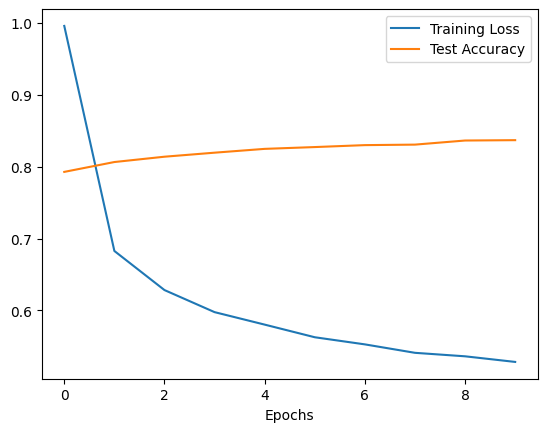

In [ ]:
fig = plt.figure() # create the canvas for plotting
ax = plt.subplot()
ax.plot(train_losses, label = "Training Loss")
ax.plot(accuracy, label = "Test Accuracy")
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel("Epochs")
ax.legend(handles, labels)